In [1]:
import os
import sys
os.environ['XLA_FLAGS'] = f"--xla_force_host_platform_device_count={os.cpu_count()}"
sys.path.append('../')
from jax import vmap, jit, grad, random, jacfwd
from jax.lax import map
import jax.numpy as jnp
import numpy as np
import time
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import warnings
from jax import config
config.update("jax_enable_x64", True)
import numpyro
numpyro.enable_x64()
from gwb.omega_gw_jax import OmegaGWjax
from interpolation.spline import Spline
from inference.numpyro_model import model
from inference.numpyro_infer import NumpyroInference
from getdist import plots,MCSamples,loadMCSamples
%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'serif'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True) # if using latex in plots
matplotlib.rc('legend', fontsize=16)


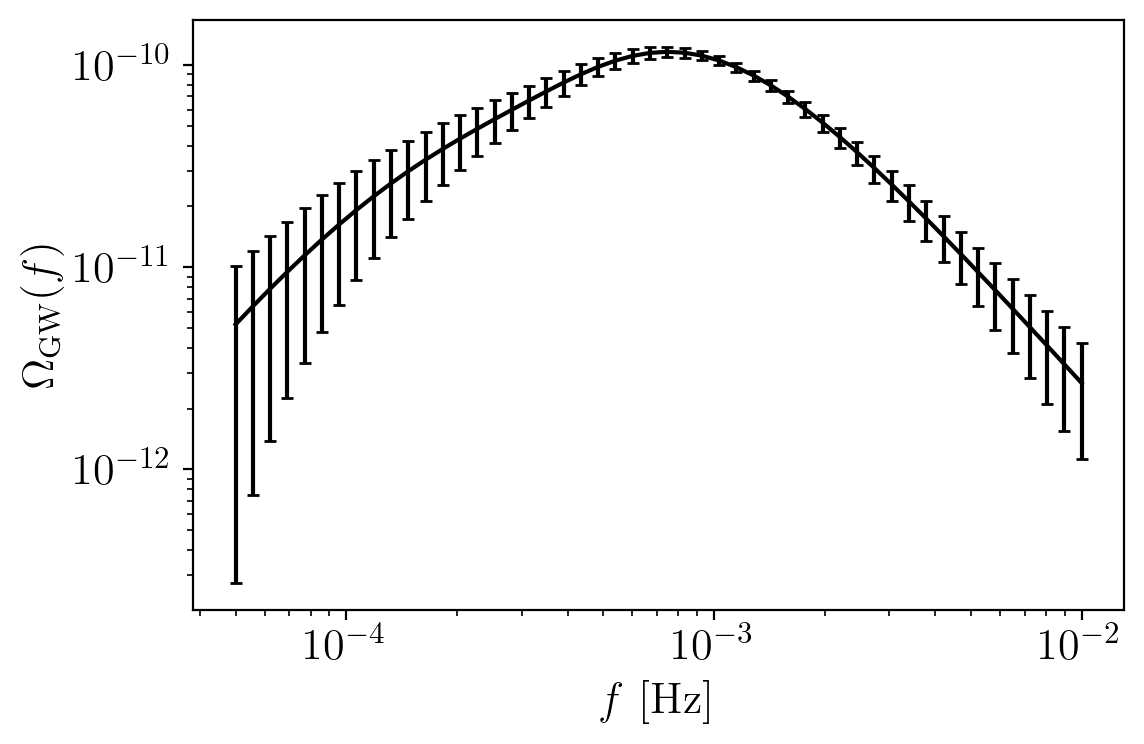

In [2]:
# load the gwb data from file and plot it
data = np.load('../bpl_data.npz')
frequencies = data['k']
Omegas = data['gw']
cov = data['cov']

plt.figure(figsize=(6,4))
plt.errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt="", color='k', label='data',capsize=2,ecolor='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$f$ [Hz]')
plt.ylabel(r'$\Omega_{\rm GW}(f)$')
plt.tight_layout()

In [3]:
# set up the interpolator
fac = 2
pk_min, pk_max = jnp.array(min(frequencies)/5), jnp.array(max(frequencies)*5)
interpolator = Spline(k_min=pk_min, k_max= pk_max,sample_nodes=False,fixed_nodes=None,num_nodes=5)

# set up the gwb calculator
s = jnp.linspace(0, 1, 10)  # First rescaled internal momentum
t = jnp.logspace(-3,3, 100)  # Second rescaled internal momentum
t_expanded = jnp.expand_dims(t, axis=-1)
## Repeat t along the new axis to match the shape (100, 1000)
t = jnp.repeat(t_expanded, len(frequencies), axis=-1)

gwb_calculator = OmegaGWjax(s,t,frequencies,norm="RD",kernel="RD")



In [5]:
# set up the inference for fixed nodes
num_nodes = 5
fixed_nodes = jnp.linspace(0,1,num_nodes)
model_args = {'num_nodes':num_nodes,  'pk_bounds': [jnp.log10(pk_min),jnp.log10(pk_max)],
              'sample_nodes': False, 'fixed_nodes': fixed_nodes, 'amp_bounds': [-6,-1],
              'interpolator': interpolator, 'gwb_calculator': gwb_calculator,
             }
sampler = NumpyroInference(model,model_args=model_args
                           ,num_samples=256,num_warmup=256,
                          )

samples, extras = sampler.run_inference(frequencies=frequencies,data=Omegas,cov=cov)

sample: 100%|██████████| 512/512 [02:40<00:00,  3.20it/s, 7 steps of size 2.55e-01. acc. prob=0.89]  


                mean       std    median      5.0%     95.0%     n_eff     r_hat
 values[0]     -4.82      0.88     -4.97     -5.95     -3.55     63.91      1.00
 values[1]     -3.42      0.10     -3.43     -3.57     -3.23     60.85      1.02
 values[2]     -2.42      0.01     -2.42     -2.43     -2.41     88.23      1.03
 values[3]     -3.12      0.04     -3.12     -3.17     -3.08     28.40      1.00
 values[4]     -3.26      0.55     -3.12     -3.95     -2.65     18.81      1.05

Number of divergences: 0


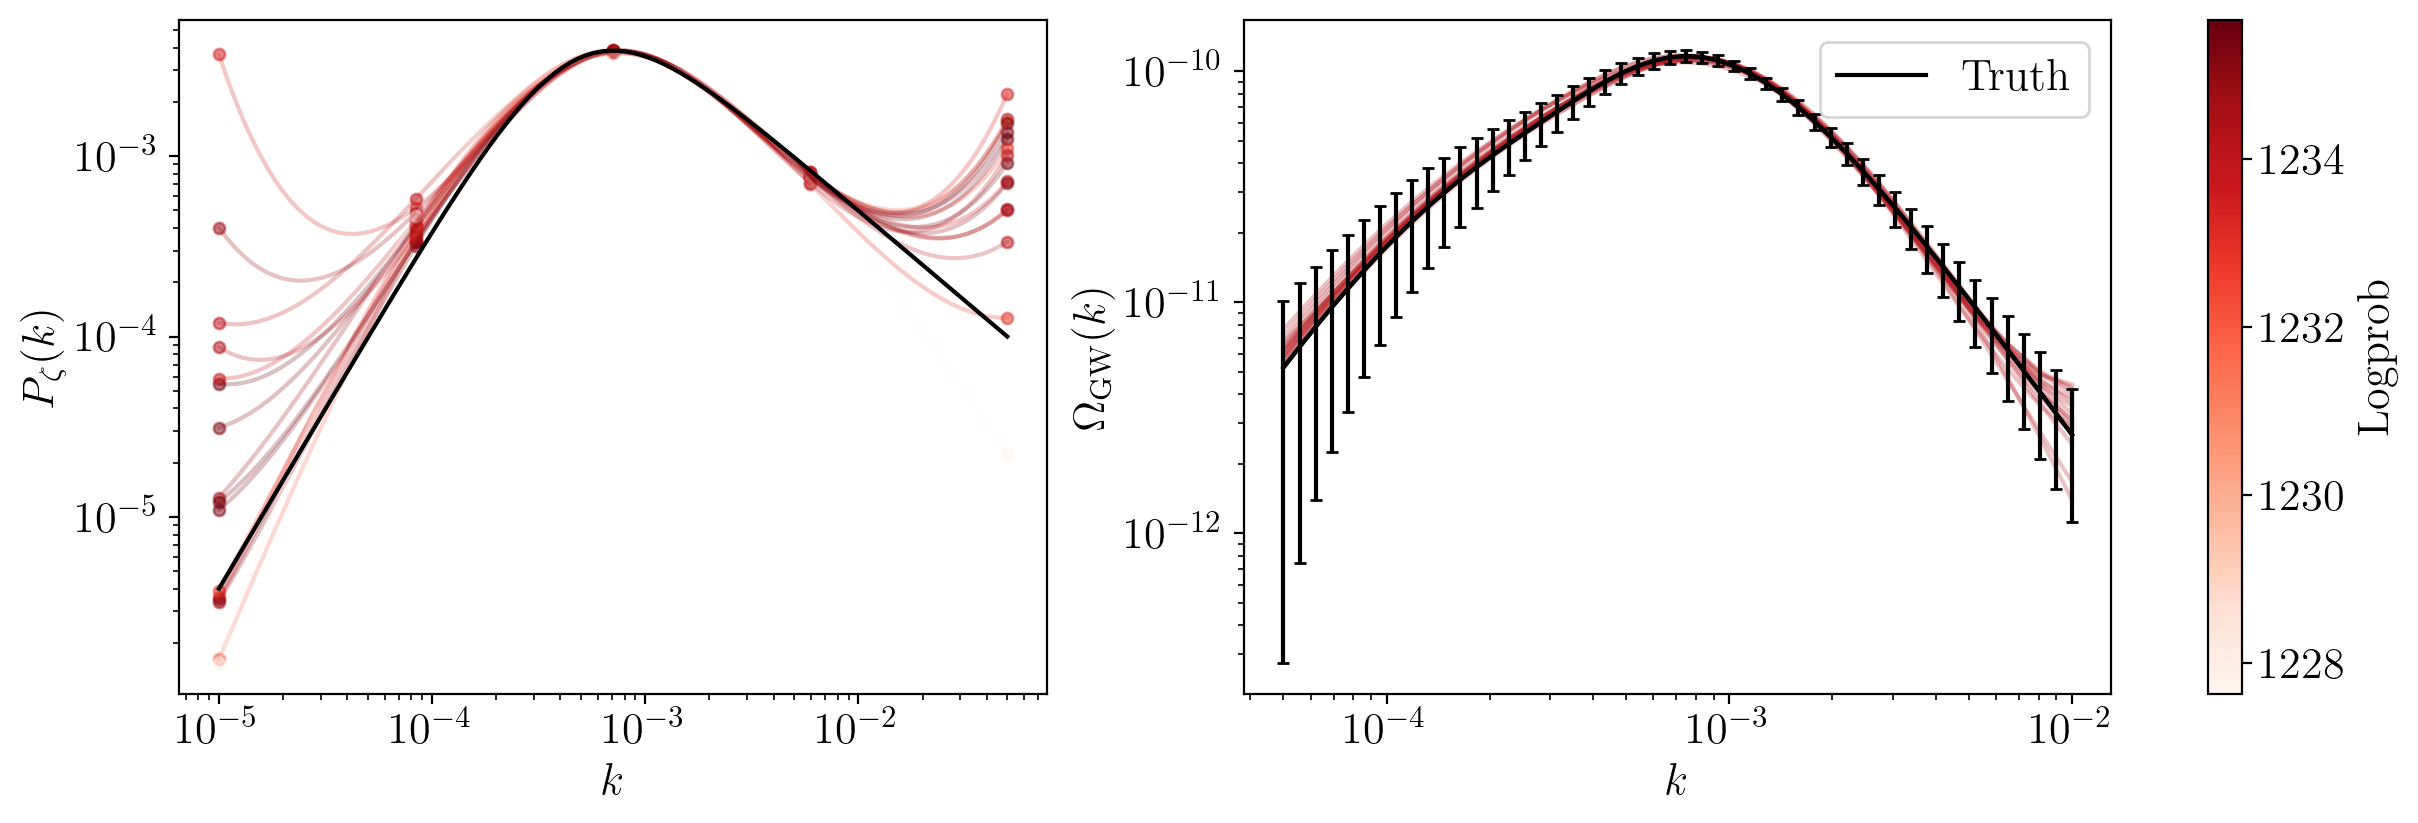

In [6]:
### Plot the MC realisations with their logprob

from interpolation.spline import spline_predict
p_arr = jnp.geomspace(pk_min*1.001,pk_max*0.999,100,endpoint=True)

thinning = 16
cmap = matplotlib.colormaps['Reds']
ys = samples['values'][::thinning]
xs = interpolator.fixed_nodes
lp = -extras["potential_energy"][::thinning] # PE = -logprob
lp_min, lp_max = np.min(lp), np.max(lp)
cols = (lp-lp_min)/(lp_max - lp_min) # normalise the logprob to a colour
norm = colors.Normalize(lp_min,lp_max)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4),layout='constrained')

def get_pz_omega(y):
    pf = interpolator.interpolate(xs, y)
    pz_amps = pf(p_arr)
    gwb_res = gwb_calculator(pf,frequencies)
    return pz_amps, gwb_res

pz_amps,gwb_amps = vmap(get_pz_omega)(ys)
# print(pz_amps[2])

for i,ps in enumerate(pz_amps):
    ax1.loglog(p_arr,ps,alpha=0.25,color=cmap(cols[i]))
    ax1.scatter(10**(xs),10**(ys[i]),s=16,alpha=0.5,color=cmap(cols[i]))
for om in gwb_amps:
    ax2.loglog(frequencies,om,alpha=0.25,color=cmap(cols[i]))

# True pz
def pz(p,pstar=5e-4,n1=2,n2=-1,sigma=2):
    nir = n1
    pl1 = (p/pstar)**nir
    nuv = (n2 - n1)/sigma
    pl2 = (1+(p/pstar)**sigma)**nuv
    return 1e-2 * pl1 * pl2
pz_amp = pz(p_arr)
ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
ax2.loglog(frequencies,Omegas,color='k',lw=1.5,label='Truth')

ax2.legend()
ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax1.set_xlabel(r'$k$')
ax2.errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt="", color='k', label='data',capsize=2,ecolor='k')

ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$k$')
fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),ax=[ax1,ax2],label='Logprob')

In [7]:
# # inference for free nodes
# num_nodes = 4
# interpolator = Spline(k_min=pk_min, k_max= pk_max,sample_nodes=True,fixed_nodes=None,num_nodes=num_nodes)
# model_args = {'num_nodes':num_nodes,  'pk_bounds': [jnp.log10(pk_min),jnp.log10(pk_max)],
#               'sample_nodes': True, 'fixed_nodes': None, 'amp_bounds': [-6,-1],
#               'interpolator': interpolator, 'gwb_calculator': gwb_calculator,
#              }
# sampler = NumpyroInference(model,model_args=model_args
#                            ,num_samples=512,num_warmup=256,
#                           )

# samples, extras = sampler.run_inference(frequencies=frequencies,data=Omegas,cov=cov)

# too slow

In [8]:
# ### Plot the MC realisations with their logprob

# from interpolation.spline import spline_predict
# p_arr = jnp.geomspace(pk_min*1.001,pk_max*0.999,100,endpoint=True)

# thinning = 16
# cmap = matplotlib.colormaps['Reds']
# ys = samples['values'][::thinning]
# xs = samples['nodes'][::thinning]
# lp = -extras["potential_energy"][::thinning] # PE = -negative logprob
# lp_min, lp_max = np.min(lp), np.max(lp)
# cols = (lp-lp_min)/(lp_max - lp_min) # normalise the logprob to a colour
# norm = colors.Normalize(lp_min,lp_max)

# fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4),layout='constrained')

# def get_pz_omega(x,y):
#     pz = interpolator.interpolate(x, y)
#     pz_amps = pz(p_arr)
#     gwb_res = gwb_calculator(pz,frequencies)
#     return pz_amps, gwb_res

# pz_amps,gwb_amps = vmap(get_pz_omega)(xs,ys)

# for i,pz in enumerate(pz_amps):
#     ax1.loglog(p_arr,pz,alpha=0.25,color=cmap(cols[i]))
#     ax1.scatter(10**(xs[i]),10**(ys[i]),s=16,alpha=0.5,color=cmap(cols[i]))
# for om in gwb_amps:
#     ax2.loglog(frequencies,om,alpha=0.25,color=cmap(cols[i]))

# # True pz
# def pz(p,pstar=5e-4,n1=2,n2=-1,sigma=2):
#     nir = n1
#     pl1 = (p/pstar)**nir
#     nuv = (n2 - n1)/sigma
#     pl2 = (1+(p/pstar)**sigma)**nuv
#     return 1e-2 * pl1 * pl2
# pz_amp = pz(p_arr)
# ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
# ax2.loglog(frequencies,Omegas,color='k',lw=1.5,label='Truth')

# ax2.legend()
# ax1.set_ylabel(r'$P_{\zeta}(k)$')
# ax1.set_xlabel(r'$k$')
# ax2.errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt="", color='k', label='data',capsize=2,ecolor='k')

# ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
# ax2.set_xlabel(r'$k$')
# fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),ax=[ax1,ax2],label='Logprob')

#### JaxNS fixed nodes

In [4]:
# now test with jaxns
import tensorflow_probability.substrates.jax as tfp
from jaxns import NestedSampler, TerminationCondition
from jaxns import Model, Prior
from jaxns.framework.special_priors import ForcedIdentifiability
tfpd = tfp.distributions


num_nodes = 5
pk_min, pk_max = jnp.array(min(frequencies)/5), jnp.array(max(frequencies)*5)
interpolator = Spline(k_min=pk_min, k_max= pk_max,sample_nodes=False,fixed_nodes=None,num_nodes=num_nodes)

def prior():
    y = yield Prior(tfpd.Uniform(low=-6*jnp.ones(num_nodes), high=-jnp.ones(num_nodes)), name='y')
    return y

fixed_nodes = interpolator.fixed_nodes

def likelihood(y):
    pf = interpolator.interpolate(fixed_nodes,y)
    gwb = gwb_calculator(pf,frequencies)
    return tfp.distributions.Normal(gwb, jnp.sqrt(jnp.diag(cov))).log_prob(Omegas).sum()

model = Model(prior, likelihood)
model.sanity_check(key=random.PRNGKey(0),S=100)

INFO:jaxns:Sanity check...
INFO:jaxns:Sanity check passed


In [5]:
exact_ns = NestedSampler(model=model, max_samples=1e5,parameter_estimation=True,verbose=False,difficult_model=True)

termination_reason, state = exact_ns(random.PRNGKey(42),term_cond=TerminationCondition(dlogZ=0.1))
results = exact_ns.to_results(termination_reason=termination_reason, state=state)
exact_ns.summary(results)

Running over 8 devices.
--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 2808340
samples: 48128
phantom samples: 39680
likelihood evals / sample: 58.4
phantom fraction (%): 82.4%
--------
logZ=1226.25 +- 0.23
max(logL)=1243.77
H=-14.95
ESS=1099
--------
y[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
y[0]: -4.64 +- 0.92 | -5.62 / -4.83 / -3.39 | -5.88 | -5.88
y[1]: -3.4 +- 0.1 | -3.52 / -3.41 / -3.26 | -3.54 | -3.54
y[2]: -2.4212 +- 0.0062 | -2.4291 / -2.4212 / -2.4132 | -2.4191 | -2.4191
y[3]: -3.122 +- 0.025 | -3.155 / -3.12 / -3.092 | -3.109 | -3.109
y[4]: -3.21 +- 0.35 | -3.67 / -3.17 / -2.8 | -3.04 | -3.04
--------


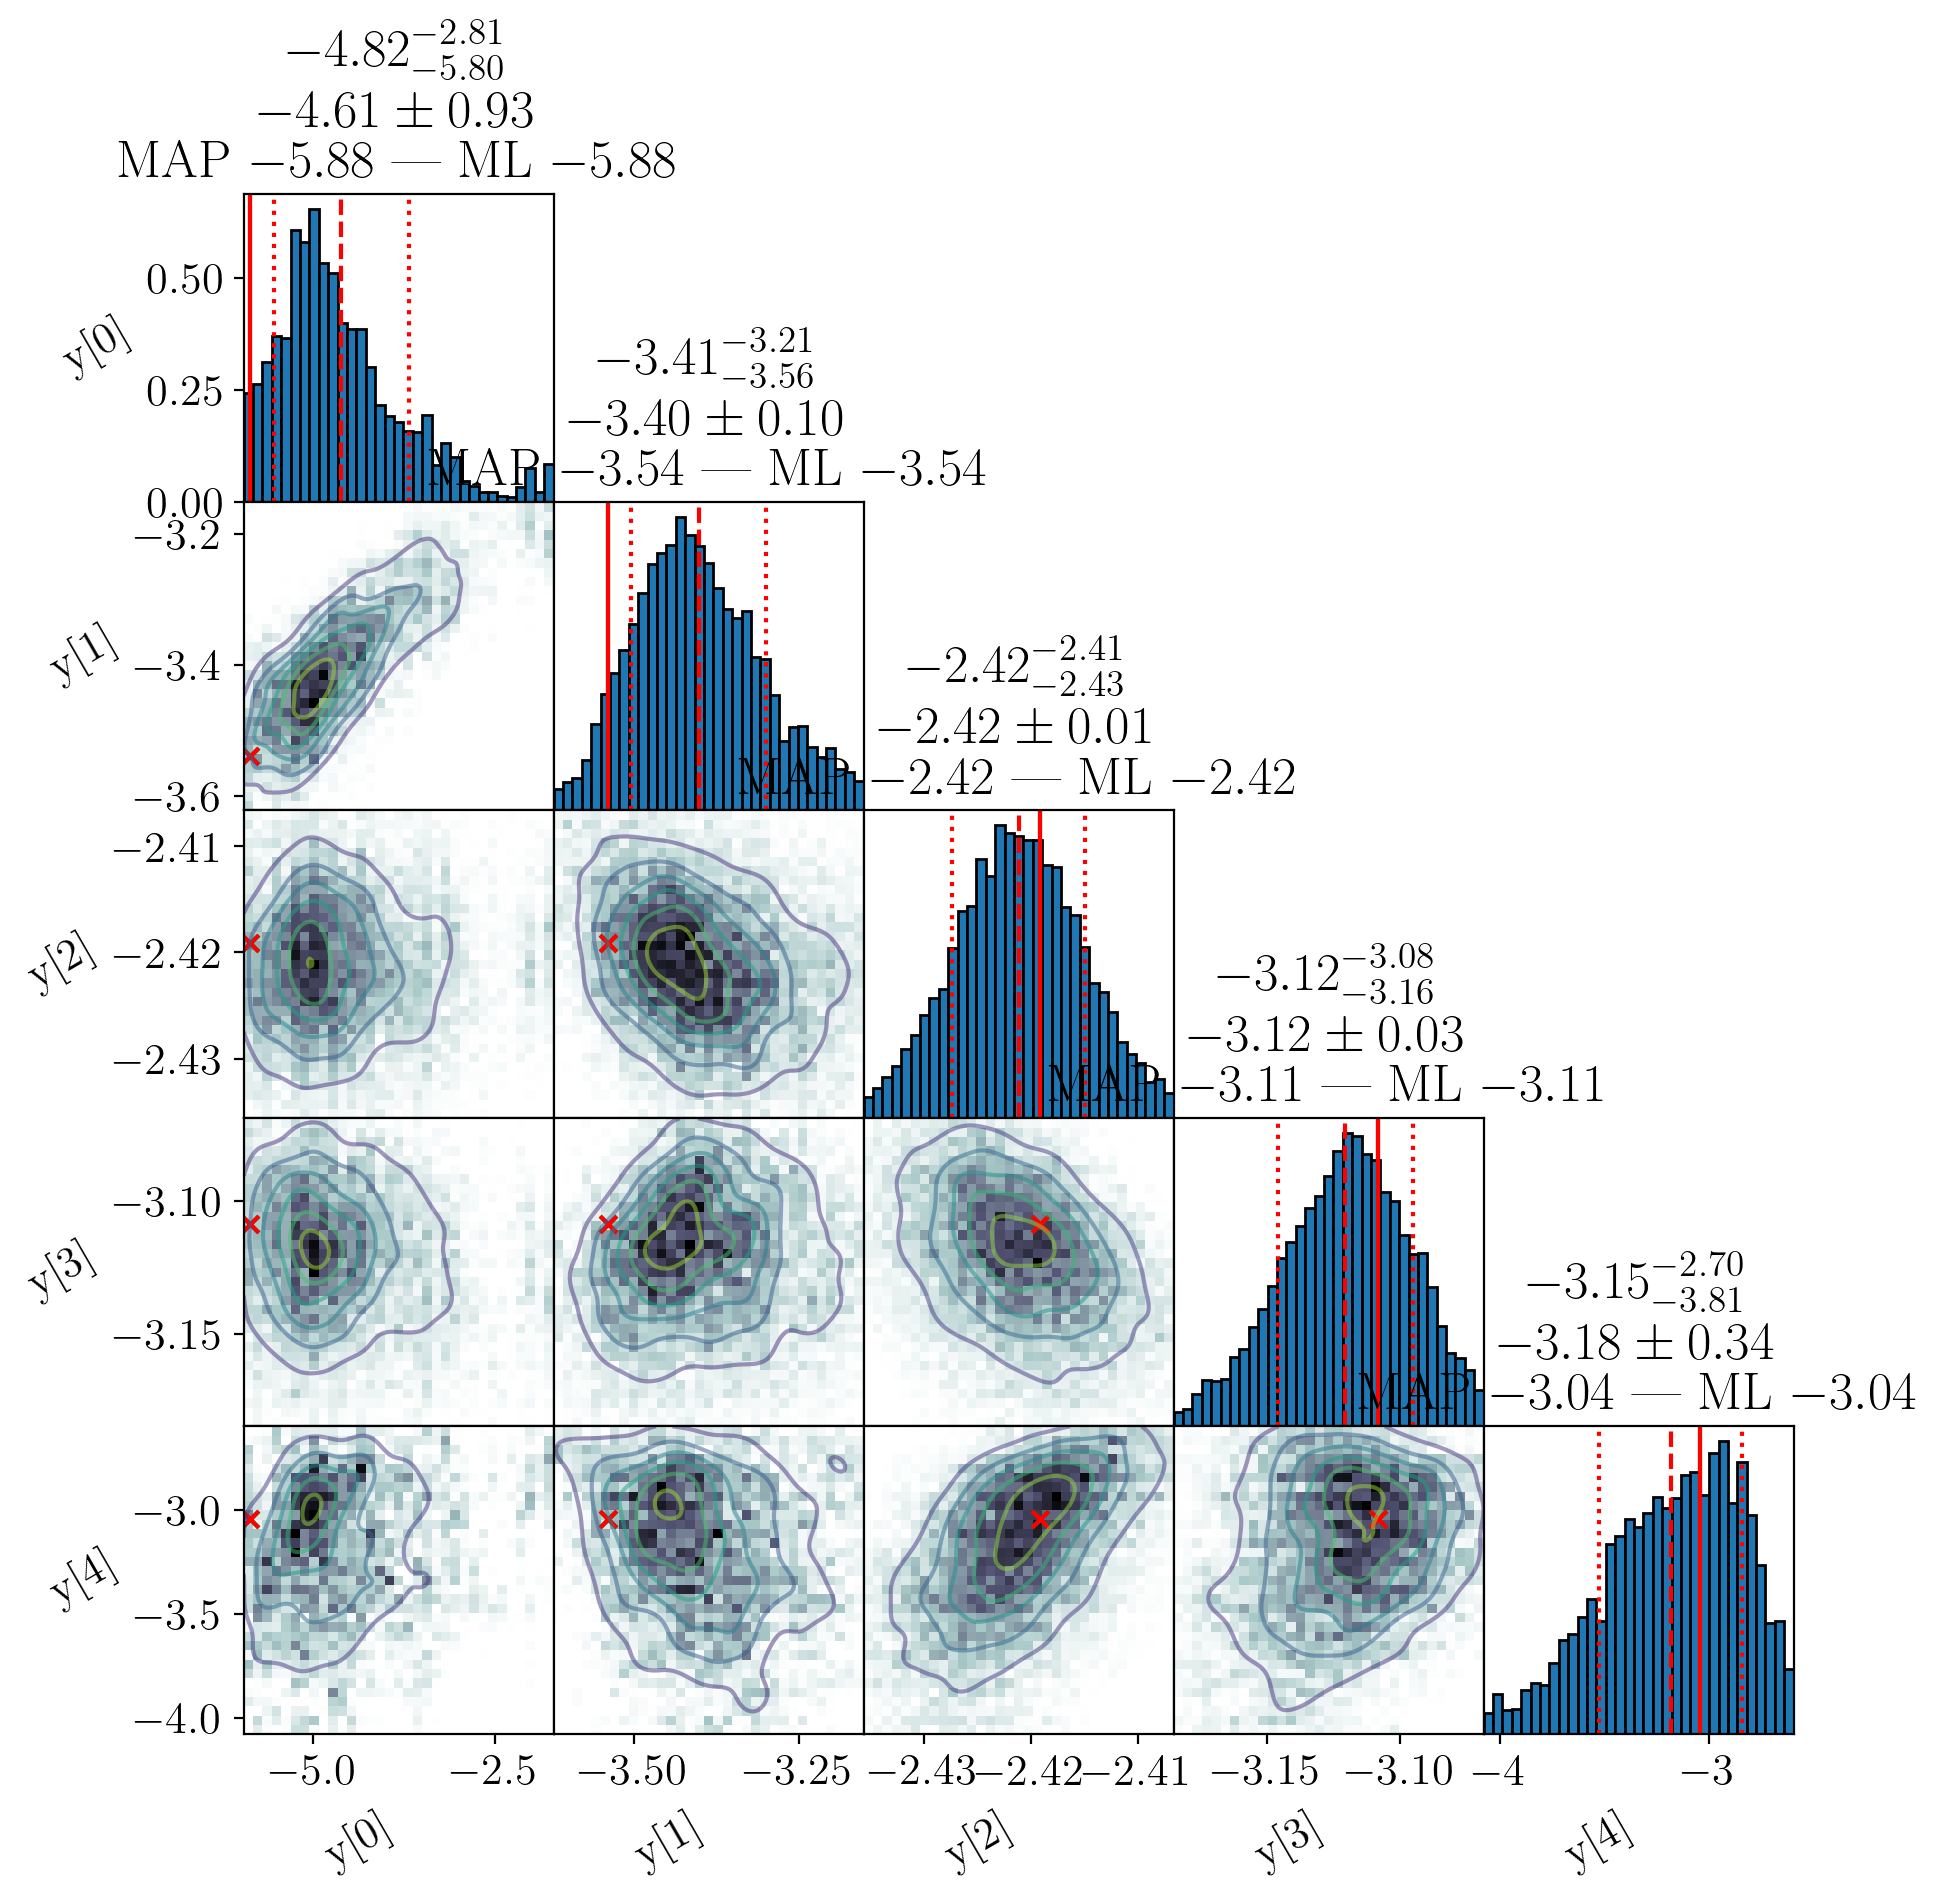

In [6]:
exact_ns.plot_cornerplot(results,kde_overlay=True,variables=['y'])

In [7]:
from jaxns import resample
samples =  resample(key=random.PRNGKey(0),
                        samples=results.samples,
                        log_weights=results.log_dp_mean, # type: ignore
                        replace=True,) 
print(samples.keys())
# print(samples['x'].shape)

dict_keys(['y'])


Text(0.5, 0, '$k$')

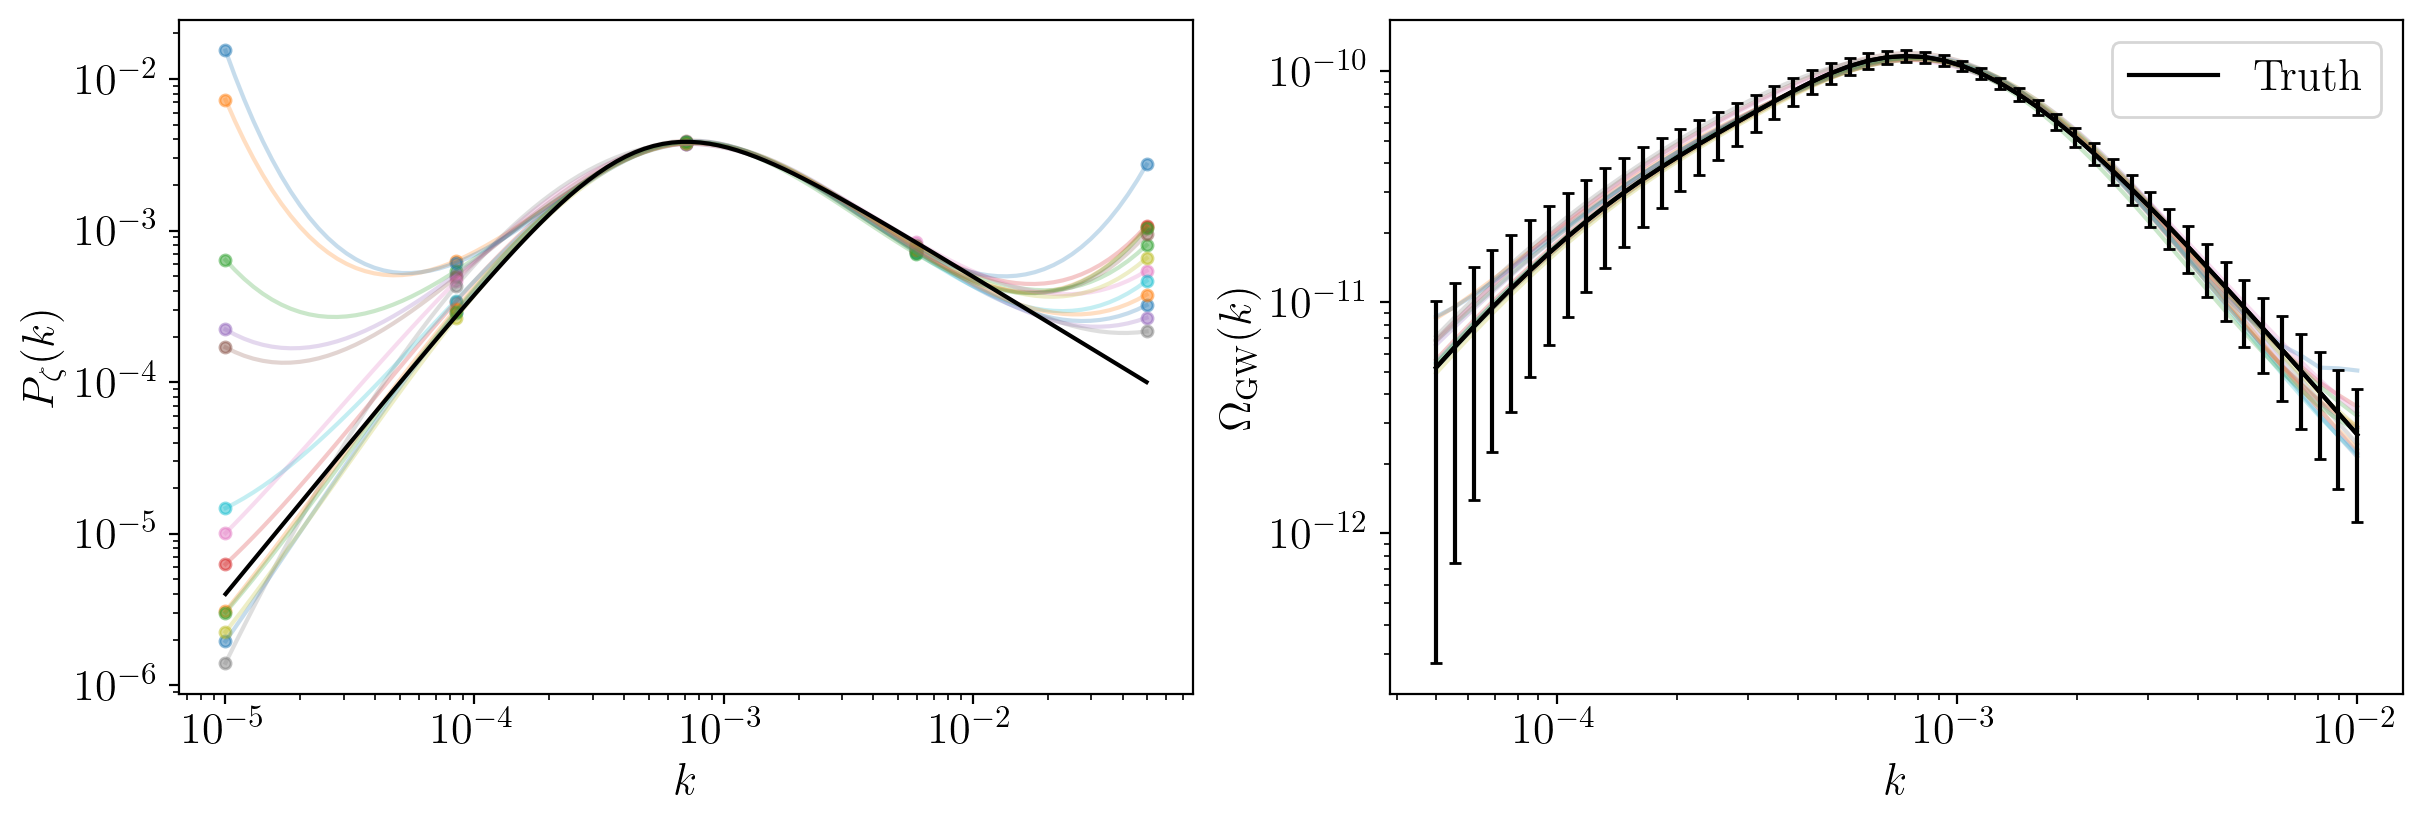

In [8]:
### Plot the MC realisations with their logprob

from interpolation.spline import spline_predict
p_arr = jnp.geomspace(pk_min*1.001,pk_max*0.999,100,endpoint=True)

thinning = 1000
cmap = matplotlib.colormaps['Reds']
ys = samples['y'][::thinning]
# xs = samples['x'][::thinning]
# lp = -extras["potential_energy"][::thinning] # PE = -negative logprob
# lp_min, lp_max = np.min(lp), np.max(lp)
# cols = (lp-lp_min)/(lp_max - lp_min) # normalise the logprob to a colour
# norm = colors.Normalize(lp_min,lp_max)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4),layout='constrained')

def get_pz_omega(y):
    pz = interpolator.interpolate(fixed_nodes, y)
    pz_amps = pz(p_arr)
    gwb_res = gwb_calculator(pz,frequencies)
    return pz_amps, gwb_res

pz_amps,gwb_amps = vmap(get_pz_omega)(ys)

for i,pz in enumerate(pz_amps):
    ax1.loglog(p_arr,pz,alpha=0.25)#,color=cmap(cols[i]))
    ax1.scatter(10**(fixed_nodes),10**(ys[i]),s=16,alpha=0.5)#,color=cmap(cols[i]))
for om in gwb_amps:
    ax2.loglog(frequencies,om,alpha=0.25)#,color=cmap(cols[i]))

# True pz
def pz(p,pstar=5e-4,n1=2,n2=-1,sigma=2):
    nir = n1
    pl1 = (p/pstar)**nir
    nuv = (n2 - n1)/sigma
    pl2 = (1+(p/pstar)**sigma)**nuv
    return 1e-2 * pl1 * pl2
pz_amp = pz(p_arr)
ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
ax2.loglog(frequencies,Omegas,color='k',lw=1.5,label='Truth')

ax2.legend()
ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax1.set_xlabel(r'$k$')
ax2.errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt="", color='k', label='data',capsize=2,ecolor='k')

ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$k$')
# fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),ax=[ax1,ax2],label='Logprob')

#### JaxNs free nodes

In [9]:
# now test with jaxns
import tensorflow_probability.substrates.jax as tfp
from jaxns import NestedSampler, TerminationCondition
from jaxns import Model, Prior
from jaxns.framework.special_priors import ForcedIdentifiability
tfpd = tfp.distributions


num_nodes = 5
pk_min, pk_max = jnp.array(min(frequencies)/5), jnp.array(max(frequencies)*5)
interpolator = Spline(k_min=pk_min, k_max= pk_max,sample_nodes=True,fixed_nodes=None,num_nodes=num_nodes)

def prior():
    x = yield ForcedIdentifiability(n=num_nodes, low=jnp.log10(pk_min), high=jnp.log10(pk_max), name='x',fix_left=True,fix_right=True)
    y = yield Prior(tfpd.Uniform(low=-6*jnp.ones(num_nodes), high=-jnp.ones(num_nodes)), name='y')
    return x, y

def likelihood(x, y):
    pf = interpolator.interpolate(x,y)
    gwb = gwb_calculator(pf,frequencies)
    return tfp.distributions.Normal(gwb, jnp.sqrt(jnp.diag(cov))).log_prob(Omegas).sum()

model = Model(prior, likelihood)
model.sanity_check(key=random.PRNGKey(0),S=100)

INFO:jaxns:Sanity check...
INFO:jaxns:Sanity check passed


In [10]:
exact_ns = NestedSampler(model=model, max_samples=5e4,parameter_estimation=True,verbose=False,difficult_model=False)

termination_reason, state = exact_ns(random.PRNGKey(42),term_cond=TerminationCondition(dlogZ=0.1))
results = exact_ns.to_results(termination_reason=termination_reason, state=state)
exact_ns.summary(results)

Running over 8 devices.
--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 849463
samples: 32640
phantom samples: 28800
likelihood evals / sample: 26.0
phantom fraction (%): 88.2%
--------
logZ=1226.91 +- 0.35
max(logL)=1244.16
H=-15.13
ESS=472
--------
x[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
x[0]: -5.0 +- 0.0 | -5.0 / -5.0 / -5.0 | -5.0 | -5.0
x[1]: -4.62 +- 0.21 | -4.89 / -4.6 / -4.41 | -4.71 | -4.71
x[2]: -3.79 +- 0.31 | -4.24 / -3.84 / -3.36 | -3.5 | -3.5
x[3]: -2.38 +- 0.5 | -2.99 / -2.48 / -1.55 | -2.66 | -2.66
x[4]: -1.3 +- 0.0 | -1.3 / -1.3 / -1.3 | -1.3 | -1.3
--------
y[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
y[0]: -3.3 +- 1.4 | -5.2 / -2.5 / -1.8 | -2.2 | -2.2
y[1]: -4.5 +- 0.89 | -5.44 / -4.89 / -3.03 | -3.43 | -3.43
y[2]: -3.37 +- 0.84 | -4.93 / -3.33 / -2.49 | -2.61 | -2.61
y[3]: -2.96 +- 0.37 | -3.5 / -2.85 / -2.49 | -2.67 | -2.67
y[4]: -3.29 +- 0.32 | -3.75 / -3.33 / -2

In [ ]:
# exact_ns.plot_diagnostics(results)

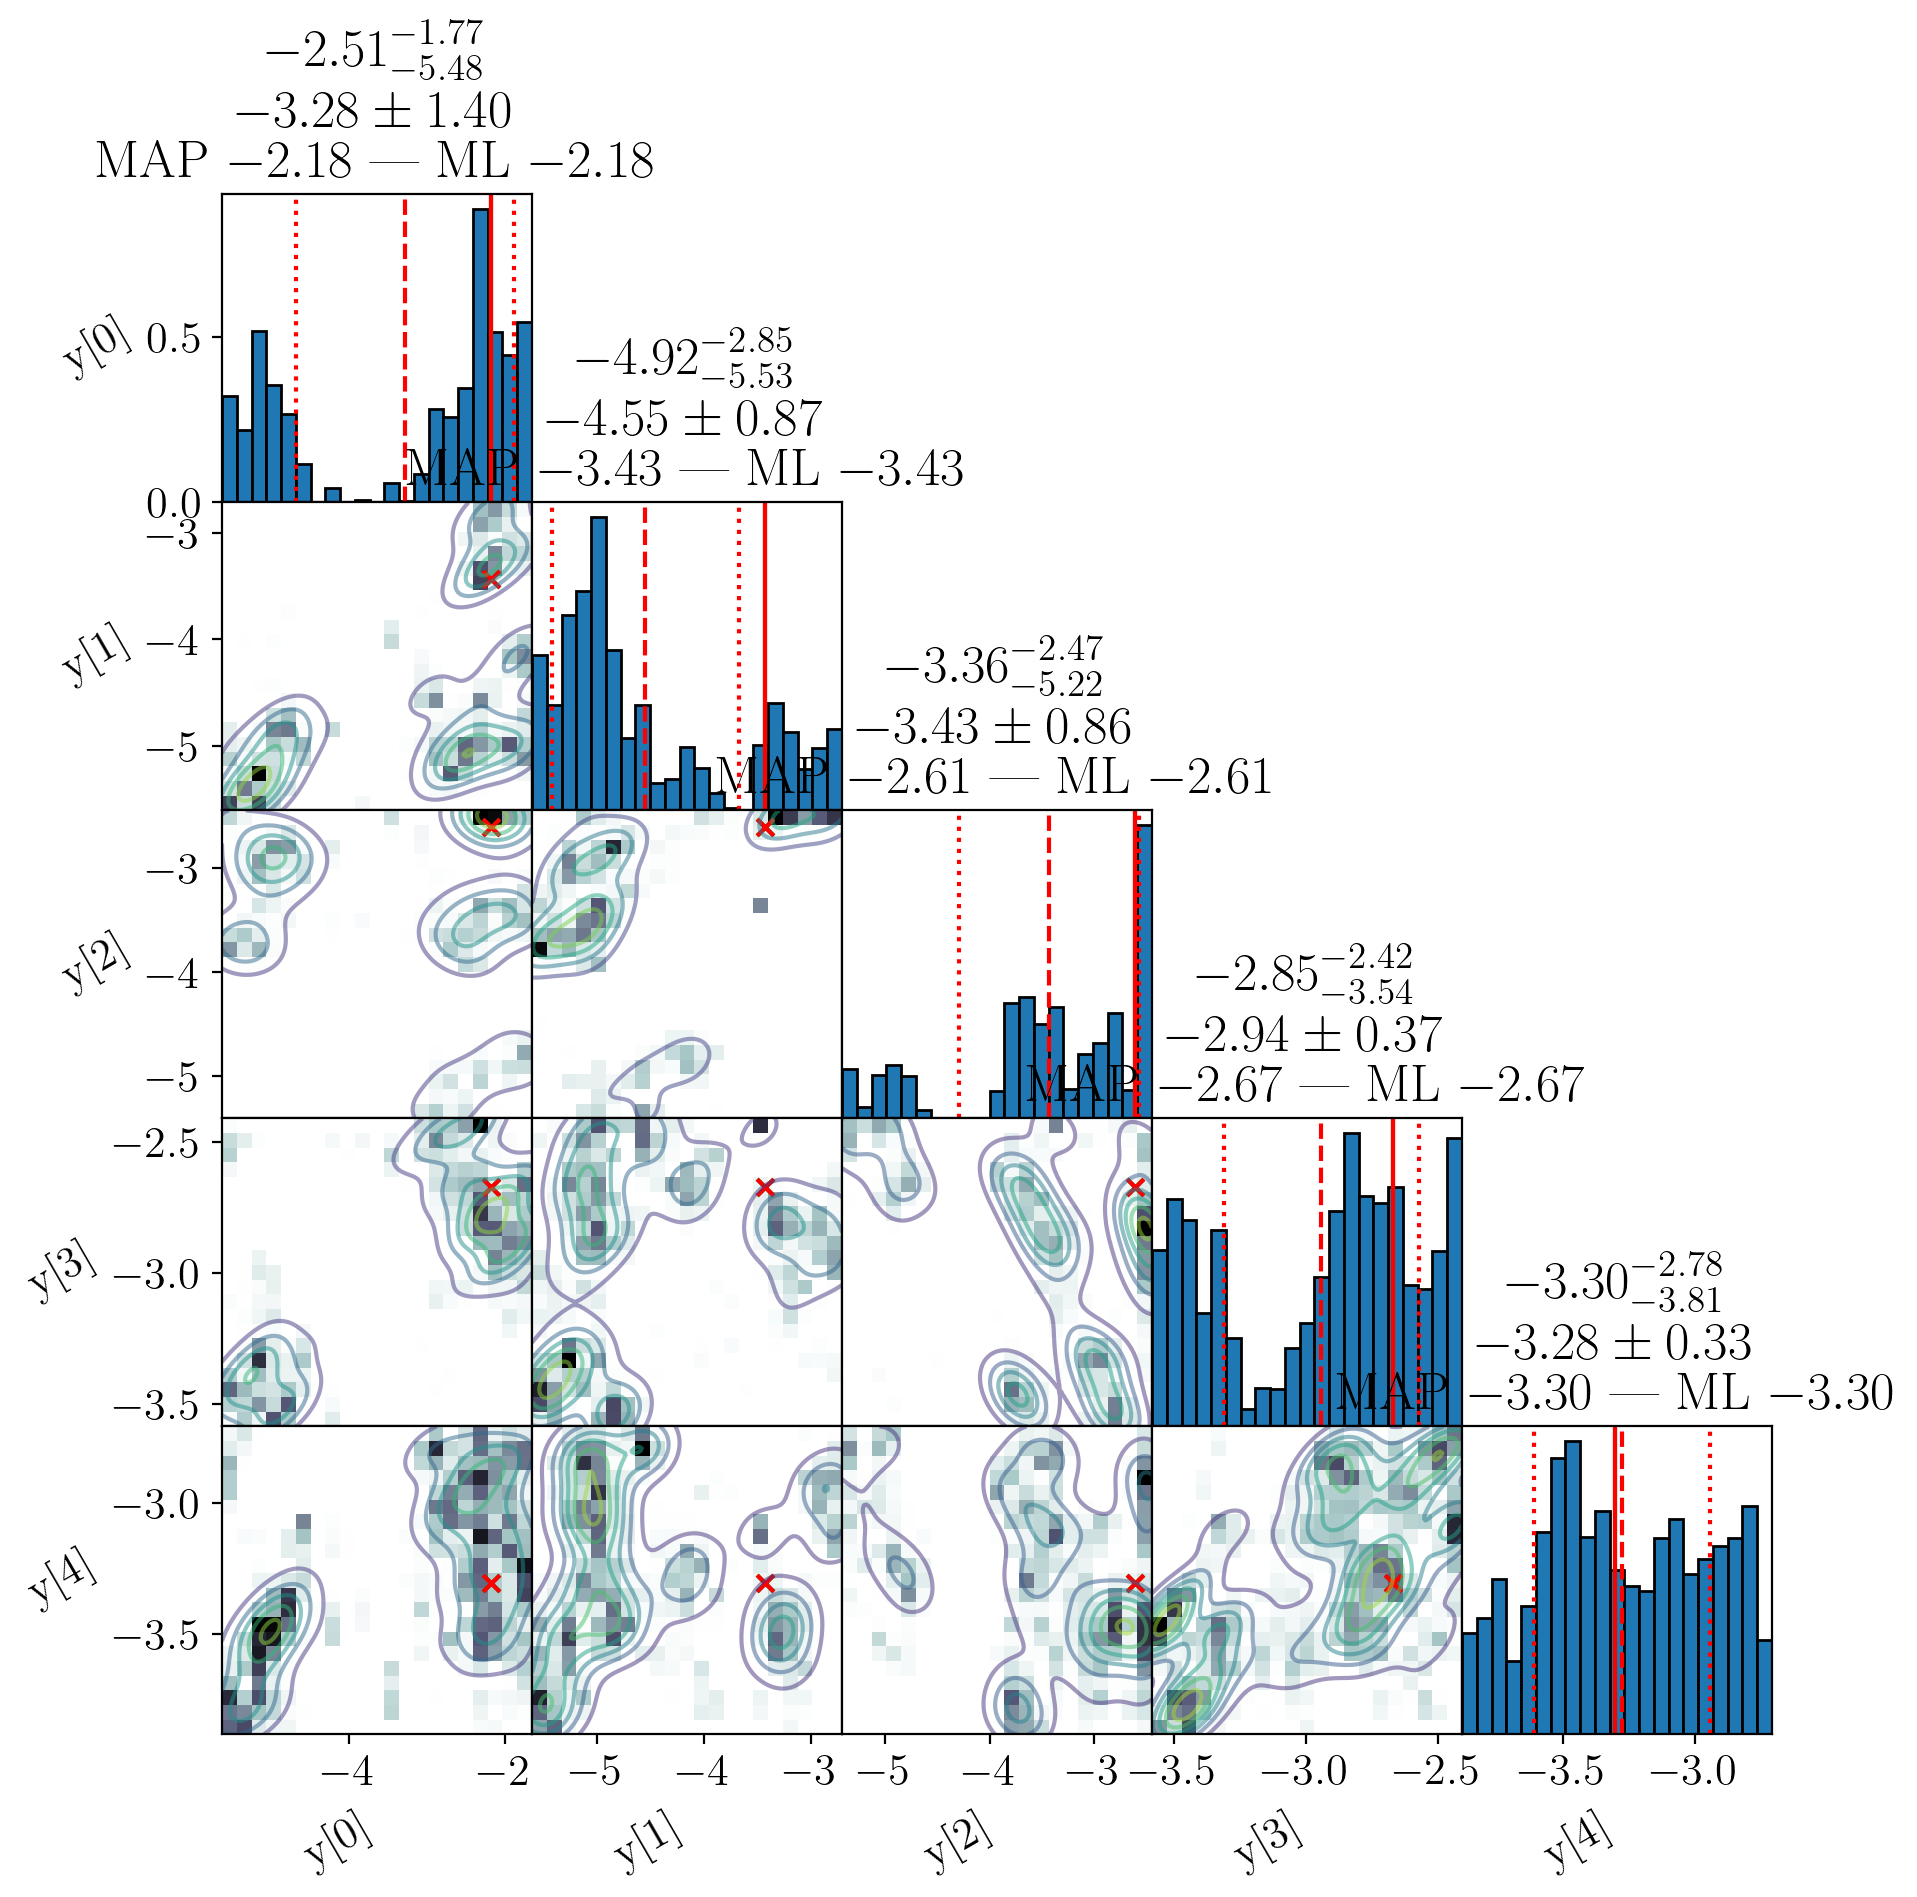

In [11]:
exact_ns.plot_cornerplot(results,kde_overlay=True,variables=['y'])

In [12]:
from jaxns import resample
samples =  resample(key=random.PRNGKey(0),
                        samples=results.samples,
                        log_weights=results.log_dp_mean, # type: ignore
                        replace=True,) 
print(samples.keys())
print(samples['y'].shape)

dict_keys(['x', 'y'])
(8145, 5)


Text(0.5, 0, '$k$')

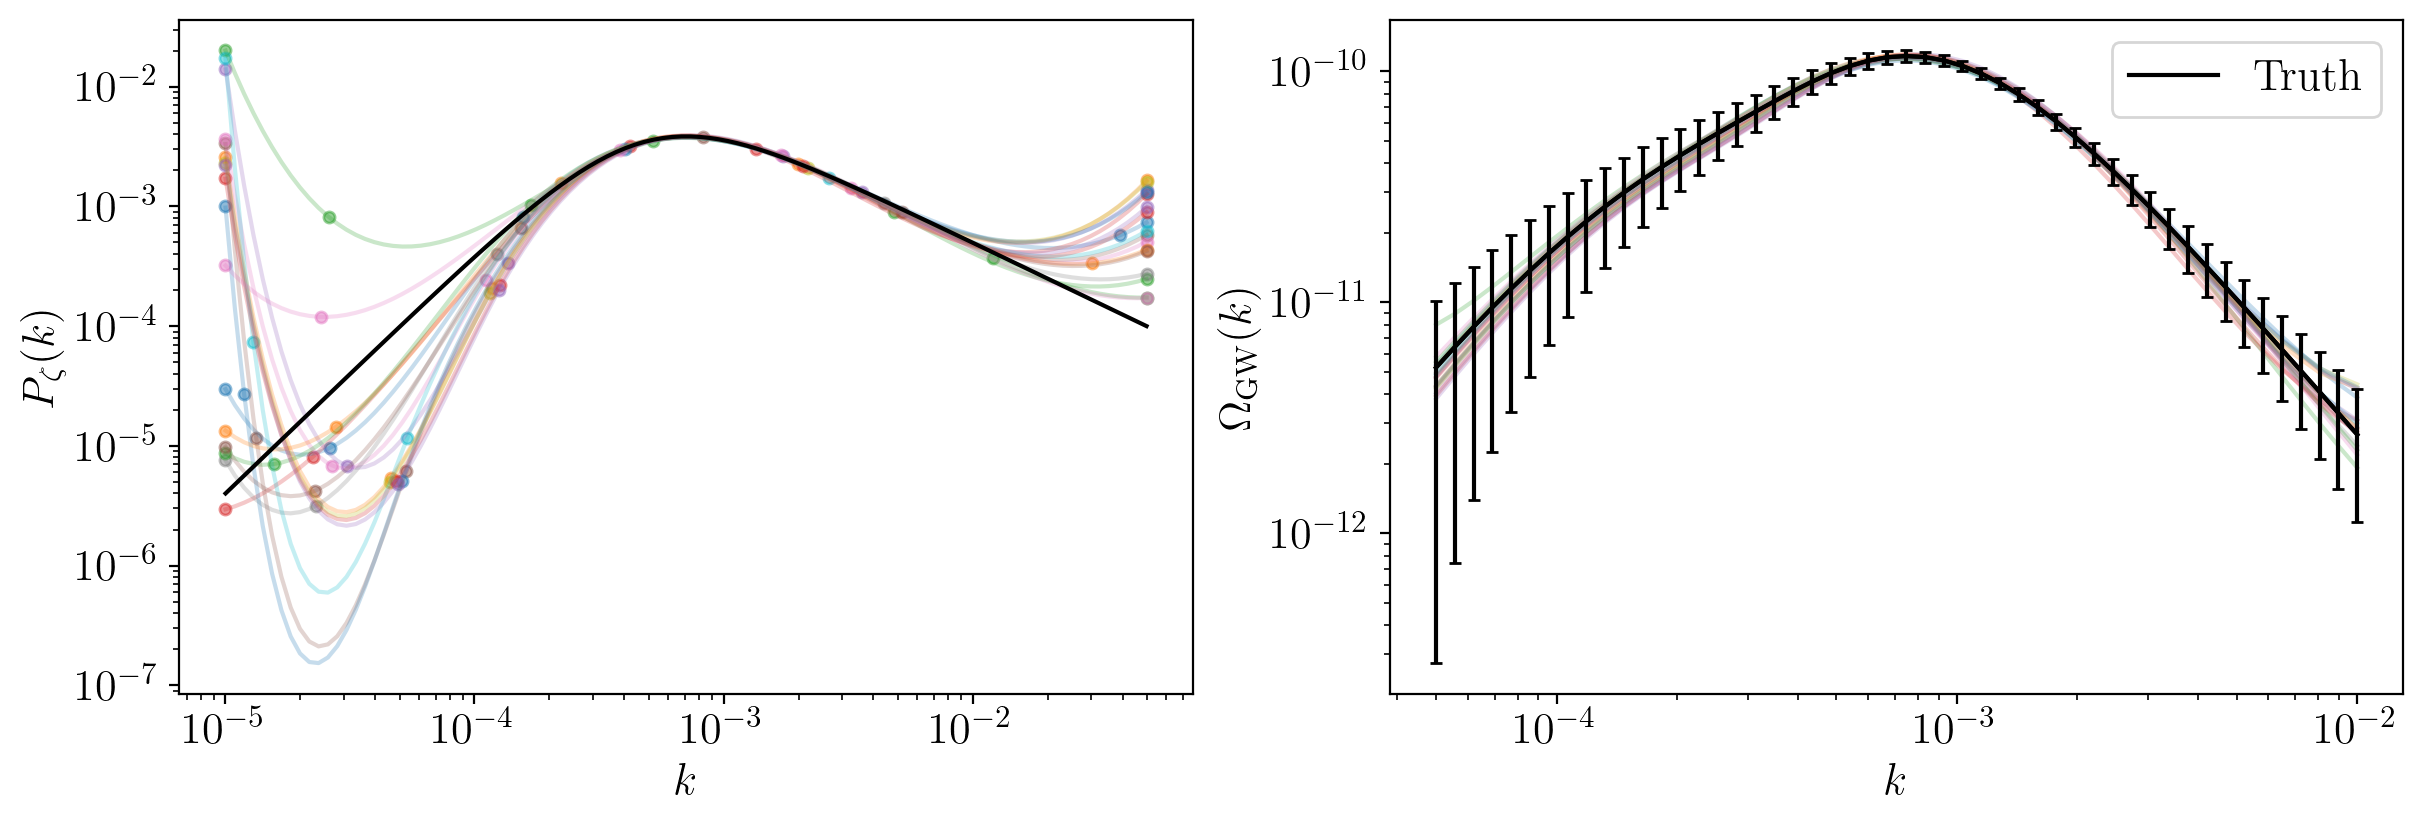

In [14]:
### Plot the MC realisations with their logprob

from interpolation.spline import spline_predict
p_arr = jnp.geomspace(pk_min*1.001,pk_max*0.999,100,endpoint=True)

thinning = samples['y'].shape[0] // 16
cmap = matplotlib.colormaps['Reds']
ys = samples['y'][::thinning]
xs = samples['x'][::thinning]
# lp = -extras["potential_energy"][::thinning] # PE = -negative logprob
# lp_min, lp_max = np.min(lp), np.max(lp)
# cols = (lp-lp_min)/(lp_max - lp_min) # normalise the logprob to a colour
# norm = colors.Normalize(lp_min,lp_max)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4),layout='constrained')

def get_pz_omega(x,y):
    pz = interpolator.interpolate(x, y)
    pz_amps = pz(p_arr)
    gwb_res = gwb_calculator(pz,frequencies)
    return pz_amps, gwb_res

pz_amps,gwb_amps = vmap(get_pz_omega)(xs,ys)

for i,pz in enumerate(pz_amps):
    ax1.loglog(p_arr,pz,alpha=0.25)#,color=cmap(cols[i]))
    ax1.scatter(10**(xs[i]),10**(ys[i]),s=16,alpha=0.5)#,color=cmap(cols[i]))
for om in gwb_amps:
    ax2.loglog(frequencies,om,alpha=0.25)#,color=cmap(cols[i]))

# True pz
def pz(p,pstar=5e-4,n1=2,n2=-1,sigma=2):
    nir = n1
    pl1 = (p/pstar)**nir
    nuv = (n2 - n1)/sigma
    pl2 = (1+(p/pstar)**sigma)**nuv
    return 1e-2 * pl1 * pl2
pz_amp = pz(p_arr)
ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
ax2.loglog(frequencies,Omegas,color='k',lw=1.5,label='Truth')

ax2.legend()
ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax1.set_xlabel(r'$k$')
ax2.errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt="", color='k', label='data',capsize=2,ecolor='k')

ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$k$')
# fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),ax=[ax1,ax2],label='Logprob')